In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/asassn/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/asassn/asassn_for_ML.csv
/kaggle/input/asassn/variable_to_solve.csv


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PowerTransformer
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
os.chdir('/kaggle/input/asassn/')
raw_DataTable=pd.read_csv('asassn_for_ML.csv')

In [4]:
col_to_drop = ['Unnamed: 0','ID']
raw_DataTable = raw_DataTable.drop(columns=col_to_drop) # drop columns that we don't need for ML

In [5]:
index_to_drop = raw_DataTable[raw_DataTable.Period.isna()].index # drop objects with undefined periods for now, we'll use  
                                             # only objects with orbital periods
DataTable = raw_DataTable.drop(index_to_drop,axis=0).copy()

In [6]:
DataTable.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 366352 entries, 0 to 378860
Data columns (total 20 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ML_classification    366352 non-null  object 
 1   Mean_gmag            366352 non-null  float64
 2   Amplitude            366352 non-null  float64
 3   Period               366352 non-null  float64
 4   parallax             365494 non-null  float64
 5   parallax_over_error  365494 non-null  float64
 6   pm                   365494 non-null  float64
 7   phot_g_mean_mag      366352 non-null  float64
 8   phot_bp_mean_mag     366346 non-null  float64
 9   phot_rp_mean_mag     366346 non-null  float64
 10  bp_rp                366346 non-null  float64
 11  FUVmag               16967 non-null   float64
 12  NUVmag               84510 non-null   float64
 13  W1mag                365370 non-null  float64
 14  W2mag                365466 non-null  float64
 15  W3mag            

array([[<AxesSubplot:title={'center':'FUVmag'}>,
        <AxesSubplot:title={'center':'NUVmag'}>]], dtype=object)

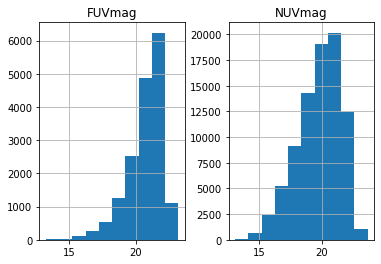

In [7]:
DataTable.hist(['FUVmag','NUVmag'])

In [7]:
# In this iteration we'll use upper limit (20.5) for NaN values 'FUVmag', 'NUVmag' from 
# https://asd.gsfc.nasa.gov/archive/galex/Documents/GALEX%20GI%20CYCLE4_files/apjl05_martin.pdf. 
# For NANs in over columns we'll use 'bfill' or 'ffill', 
# before that we order the table by columns 'ML_classification' & 'phot_g_mean_mag' 

FUV_HUV = DataTable[['FUVmag','NUVmag']].fillna(20.5)
DataTable[['FUVmag','NUVmag']] = FUV_HUV
DataTable = DataTable.sort_values(['ML_classification','phot_g_mean_mag'])
DataTable = DataTable.fillna(method = 'ffill') # there are about 1500 NaN ~ 0.4% of the sample

In [21]:
#sns.set(rc={'figure.figsize':(15,10)})
#sns.heatmap(DataTable.corr())

In [8]:
DataTable.isna().sum()

ML_classification      0
Mean_gmag              0
Amplitude              0
Period                 0
parallax               0
parallax_over_error    0
pm                     0
phot_g_mean_mag        0
phot_bp_mean_mag       0
phot_rp_mean_mag       0
bp_rp                  0
FUVmag                 0
NUVmag                 0
W1mag                  0
W2mag                  0
W3mag                  0
W4mag                  0
Jmag                   0
Hmag                   0
Kmag                   0
dtype: int64

In [9]:
# Build feature/target arrays
X, y = DataTable.drop("ML_classification", axis=1), DataTable["ML_classification"]

In [31]:
#Solution with normal scaling for all columns

# Set up the colnames
to_scale = ['Mean_gmag', 'phot_g_mean_mag',
       'phot_bp_mean_mag', 'phot_rp_mean_mag',
       'W1mag', 'W2mag', 'W3mag', 'Jmag', 'Hmag', 'Kmag', 'Amplitude', 
            'Period','parallax', 'parallax_over_error', 'pm', 'bp_rp', 
          'FUVmag', 'NUVmag', 'W4mag']
to_log = []
categorical = X.select_dtypes(include="category").columns

#we use two methods to compare
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

LR_pipe = Pipeline([("prep", transformer), ("logistic_reg", LogisticRegression())])
knn_pipe = Pipeline([("prep", transformer), ("knn", KNeighborsClassifier())])

from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder

# Train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

# Encode the target
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
# Fit/predict/score
_knn = knn_pipe.fit(X_train, y_train)
preds_knn = knn_pipe.predict_proba(X_test)
_LR = LR_pipe.fit(X_train, y_train)
preds_LR = LR_pipe.predict_proba(X_test)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [39]:
roc_knn = roc_auc_score(y_test,preds_knn,multi_class='ovr',average='weighted')
roc_knn

0.9541561476359603

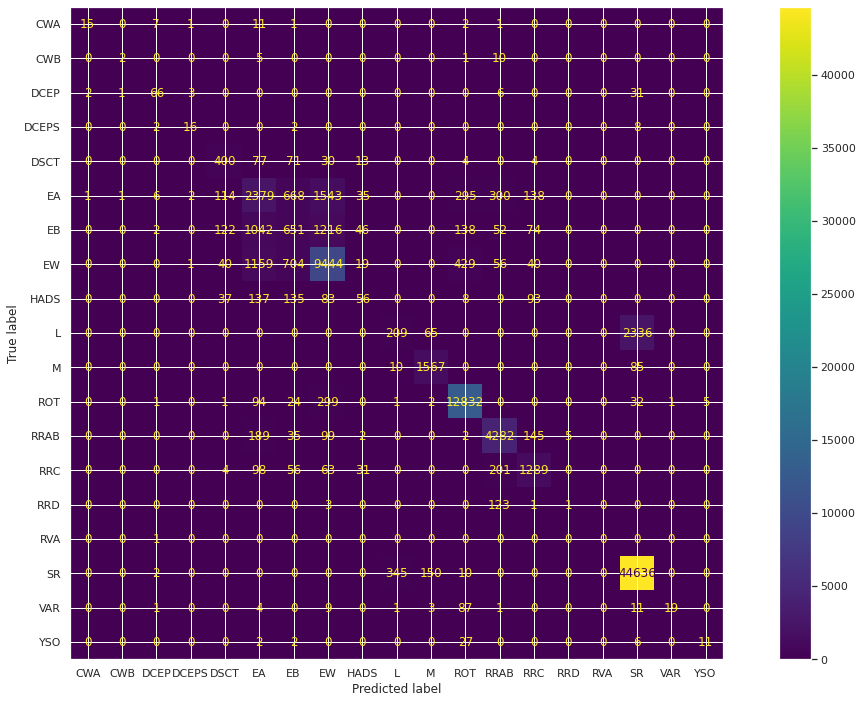

In [40]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

pred_knn = knn_pipe.predict(X_test)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(20, 12))
# Create the matrix
cm = confusion_matrix(y_test, pred_knn)
cmp = ConfusionMatrixDisplay(cm, display_labels=le.inverse_transform(knn_pipe.classes_))
cmp.plot(ax=ax)

plt.show();

In [ ]:
pred_LR = knn_LR.predict(X_test)
# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(20, 12))
# Create the matrix
cm = confusion_matrix(y_test, pred_LR)
cmp = ConfusionMatrixDisplay(cm, display_labels=le.inverse_transform(LR_pipe.classes_))
cmp.plot(ax=ax)

plt.show();

In [21]:
#Solution with normal scaling & logorithm scaling for columns with skewed distribution 
#(https://towardsdatascience.com/how-to-differentiate-between-scaling-normalization-and-log-transformations-69873d365a94)
# increase number of iterations up to 200 for LinearRegression

# Set up the colnames
to_scale = ['Mean_gmag', 'phot_g_mean_mag',
       'phot_bp_mean_mag', 'phot_rp_mean_mag',
       'W1mag', 'W2mag', 'W3mag', 'Jmag', 'Hmag', 'Kmag']
to_log = ['Amplitude', 
            'Period','parallax', 'parallax_over_error', 'pm', 'bp_rp', 
          'FUVmag', 'NUVmag', 'W4mag']
categorical = X.select_dtypes(include="category").columns

#creating functions for pipeline

scale_pipe = make_pipeline(StandardScaler())
log_pipe = make_pipeline(PowerTransformer())
categorical_pipe = make_pipeline(OneHotEncoder(sparse=False, handle_unknown="ignore"))

transformer = ColumnTransformer(
    transformers=[
        ("scale", scale_pipe, to_scale),
        ("log_transform", log_pipe, to_log),
        ("oh_encode", categorical_pipe, categorical),
    ]
)
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

LR_pipe = Pipeline([("prep", transformer), 
                    ("logistic_reg", LogisticRegression(multi_class = 'ovr', solver = 'liblinear'))])
knn_pipe = Pipeline([("prep", transformer), ("knn", KNeighborsClassifier())])

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

from sklearn.preprocessing import LabelEncoder
# Encode the target
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
# Fit/predict/score
_knn_with_log = knn_pipe.fit(X_train, y_train)
preds_knn_with_log = knn_pipe.predict_proba(X_test)
_LR_with_log = LR_pipe.fit(X_train, y_train)
preds_LR_with_log = LR_pipe.predict_proba(X_test)


In [30]:
from sklearn.metrics import roc_auc_score
roc_knn_with_log = roc_auc_score(y_test,preds_knn_with_log,multi_class='ovr')
roc_LR_with_log = roc_auc_score(y_test,preds_LR_with_log,multi_class='ovr')
print, roc_knn_with_log, roc_LR_with_log

(<function print>, 0.8685067910065292, 0.9727435403885726)

In [27]:
pred_knn_with_log = knn_pipe.predict(X_test)
pred_LR_with_log = LR_pipe.predict(X_test)

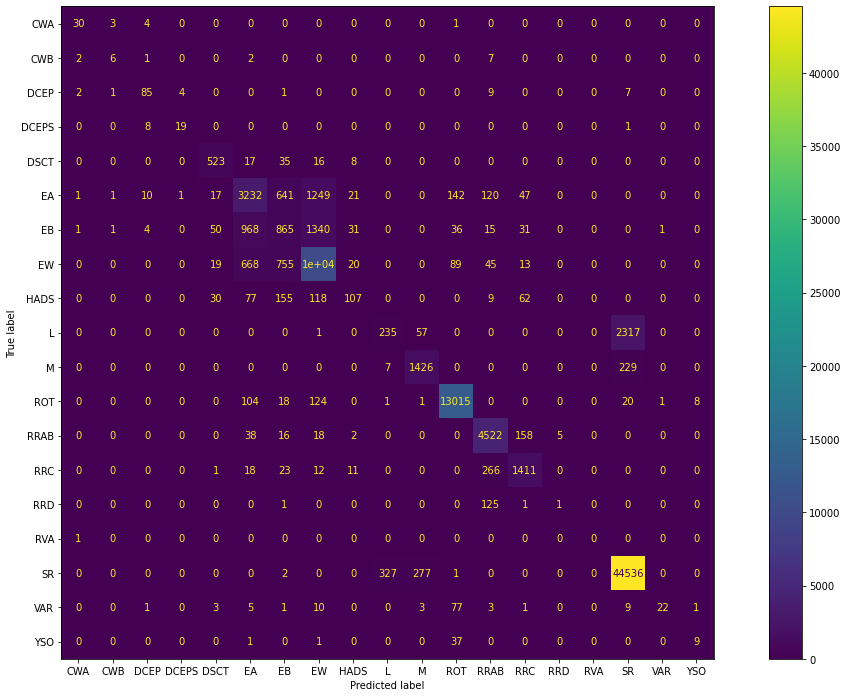

In [28]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(20, 12))
# Create the matrix
cm = confusion_matrix(y_test, pred_knn_with_log)
cmp = ConfusionMatrixDisplay(cm, display_labels=le.inverse_transform(knn_pipe.classes_))
cmp.plot(ax=ax)

plt.show();

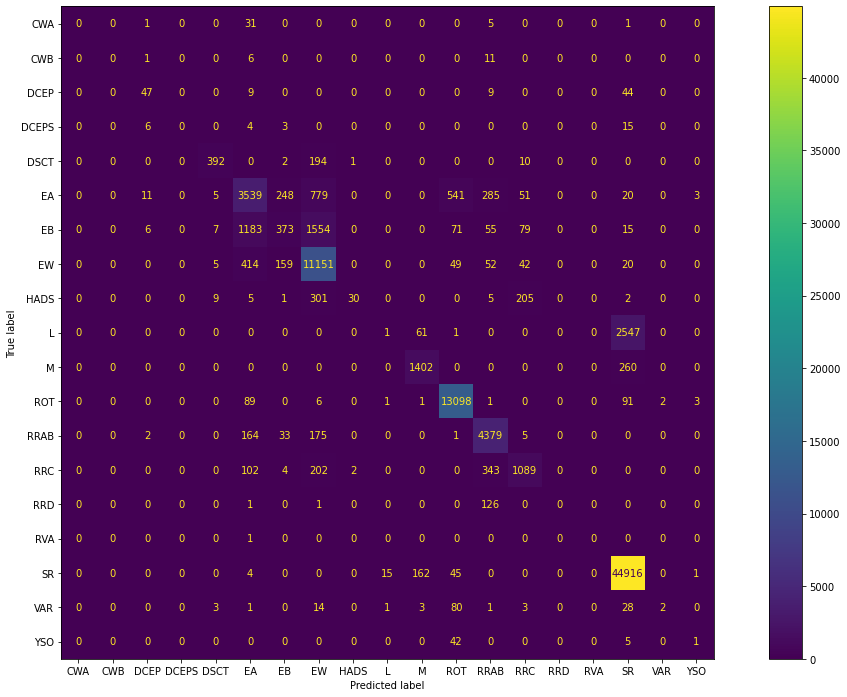

In [29]:
# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(20, 12))
# Create the matrix
cm = confusion_matrix(y_test, pred_LR_with_log)
cmp = ConfusionMatrixDisplay(cm, display_labels=le.inverse_transform(LR_pipe.classes_))
cmp.plot(ax=ax)

plt.show();